#GAN#


### load and view

In [ ]:
# prompt: load the dataset from from google drive with input urk

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Replace 'your_file_path' with the actual path to your file in Google Drive
file_path = '/content/drive/MyDrive/GAN/fusion_with_vector_extended.csv' #@param {type:"string"}

try:
  df = pd.read_csv(file_path)
  print("Dataset loaded successfully.")
  # You can now work with the DataFrame 'df'
  print(df.head())
except FileNotFoundError:
  print(f"Error: File not found at {file_path}. Please check the file path.")
except Exception as e:
  print(f"An error occurred: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully.
                                        Full Payload       Label  \
0  \C:\\Windows\\System32\\WindowsPowerShell\\v1....    Injector   
1  \C:\\Windows\\System32\\WindowsPowerShell\\v1....  Downloader   
2  \C:\\Windows\\System32\\WindowsPowerShell\\v1....    Injector   
3  powershell.exe -nop -wind hidden -Exec Bypass ...     Payload   
4  powershell -window hidden -enc $1 = '$c = ''[D...    Injector   

                                        FusionVector  
0  -0.18999852 -0.48553216 -0.87083316 0.2666215 ...  
1  -0.3947524 0.010655806 -0.67612636 -0.07839656...  
2  -0.1899367 -0.5148512 -0.90198445 0.2528152 -0...  
3  -0.17432946 0.028123861 -0.5588947 -0.03192398...  
4  -0.24262634 -0.5209265 -0.8235193 0.15971158 -...  


In [ ]:
df.head()

,Full Payload,Label,FusionVector
0,\C:\\Windows\\System32\\WindowsPowerShell\\v1....,Injector,-0.18999852 -0.48553216 -0.87083316 0.2666215 ...
1,\C:\\Windows\\System32\\WindowsPowerShell\\v1....,Downloader,-0.3947524 0.010655806 -0.67612636 -0.07839656...
2,\C:\\Windows\\System32\\WindowsPowerShell\\v1....,Injector,-0.1899367 -0.5148512 -0.90198445 0.2528152 -0...
3,powershell.exe -nop -wind hidden -Exec Bypass ...,Payload,-0.17432946 0.028123861 -0.5588947 -0.03192398...
4,powershell -window hidden -enc $1 = '$c = ''[D...,Injector,-0.24262634 -0.5209265 -0.8235193 0.15971158 -...


In [ ]:
# prompt: df.head() and save it to dataset file in type csv in /content/drive/MyDrive/GAN/  with name sample_fushion

import os

# Create the directory if it doesn't exist
output_dir = "/content/drive/MyDrive/GAN/"
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, "sample_fushion.csv")

df.head().to_csv(output_file, index=False)


#### code below is still ok, but wanna add a mechanisum to handel and process value in Label

## Check point to run project

#### because of built-in -> input of GAN is dataset, and output also dataset ( noise in Fushion Vector)


#### dataset input format: fullpayload-label-fushion
#### output have same format, with name synthetic_powershell_malware


####suitable gan - built in discrim

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load and preprocess dataset
def load_and_preprocess_data(csv_path, scaler_params, feature_dim=512):
    # Load CSV
    data = pd.read_csv(csv_path)

    # Define valid labels
    valid_labels = {'Bypass', 'Downloader', 'Injector', 'Payload', 'TaskExecution'}

    # Log original number of rows
    original_rows = len(data)

    # Filter rows with valid labels
    data = data[data['Label'].isin(valid_labels)]

    # Log number of rows removed
    removed_rows = original_rows - len(data)
    if removed_rows > 0:
        print(f"Removed {removed_rows} rows with invalid labels.")
    else:
        print("No rows with invalid labels found.")

    # Check if data is empty
    if data.empty:
        raise ValueError("No rows remain after filtering. Check dataset labels.")

    # Print unique labels
    unique_labels = data['Label'].unique()
    print(f"Unique labels after filtering: {unique_labels}")

    # Parse FusionVector
    features = np.array([np.fromstring(vec, sep=' ') for vec in data['FusionVector']])

    # Validate feature dimension
    assert features.shape[1] == feature_dim, f"Expected {feature_dim} features, got {features.shape[1]}"

    # Normalize features using saved scaler
    scaler = StandardScaler()
    scaler.mean_, scaler.scale_ = scaler_params[0], scaler_params[1]
    features = scaler.transform(features)

    # Convert to PyTorch tensors
    features = torch.FloatTensor(features)

    return features, data, scaler

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super(Discriminator, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)  # 5 classes
        )
        self.real_fake = nn.Linear(128, 1)

    def forward(self, x):
        features = self.classifier[:-1](x)
        class_logits = self.classifier[-1](features)
        real_fake_logit = self.real_fake(features)
        return torch.cat([class_logits, real_fake_logit], dim=1)

# Generator Model
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        # Add small noise to input for diversity
        noise = torch.randn_like(x) * 0.05
        return self.model(x + noise)

# Train GAN
def train_gan(discriminator, generator, features, noise_dim=100, epochs=200, batch_size=64, lr=0.0002):
    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    adversarial_loss = nn.BCEWithLogitsLoss()

    discriminator.eval()
    for param in discriminator.parameters():
        param.requires_grad = False

    generator.train()
    for epoch in range(epochs):
        total_g_loss = 0
        for i in range(0, len(features), batch_size):
            real_data = features[i:i+batch_size]
            batch_size_actual = real_data.size(0)

            noise = torch.randn(batch_size_actual, noise_dim)
            fake_data = generator(noise)
            real_validity = torch.ones(batch_size_actual, 1)

            g_optimizer.zero_grad()
            g_output = discriminator(fake_data)
            g_loss = adversarial_loss(g_output[:, -1:], real_validity)
            g_loss.backward()
            g_optimizer.step()
            total_g_loss += g_loss.item()

        if (epoch + 1) % 10 == 0:
            avg_g_loss = total_g_loss / (len(features) // batch_size + 1)
            print(f"Epoch {epoch+1}/{epochs}, Generator Loss: {avg_g_loss:.4f}")

    return generator

# Generate synthetic dataset
def generate_synthetic_dataset(generator, num_samples, noise_dim, scaler, label_encoder_classes, input_data, copy_payload=False):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, noise_dim)
        synthetic_data = generator(noise).numpy()

    synthetic_data = scaler.inverse_transform(synthetic_data)
    synthetic_labels = np.random.choice(label_encoder_classes, size=num_samples)

    # Handle Full Payload
    if copy_payload:
        # Randomly sample Full Payload from input dataset
        payload_values = input_data['Full Payload'].dropna().sample(num_samples, replace=True).values
    else:
        # Use empty strings
        payload_values = [''] * num_samples

    # Create synthetic dataset
    synthetic_df = pd.DataFrame({
        'Full Payload': payload_values,
        'Label': synthetic_labels,
        'FusionVector': [' '.join(map(str, vec)) for vec in synthetic_data]
    })

    return synthetic_df

# Main execution
if __name__ == "__main__":
    # Hyperparameters
    feature_dim = 512
    noise_dim = 100
    batch_size = 64
    epochs = 200
    num_classes = 5
    copy_payload = False  # Set to True to copy random Full Payload values

    # Load dataset and scaler
    csv_path = "/content/drive/MyDrive/GAN/fusion_with_vector_extended.csv"  # Placeholder
    try:
        scaler_params = np.load("scaler_params.npy", allow_pickle=True)
        features, original_data, scaler = load_and_preprocess_data(csv_path, scaler_params, feature_dim)
    except Exception as e:
        print(f"Error loading dataset or scaler: {e}")
        exit(1)

    # Load label encoder classes
    try:
        label_encoder_classes = np.load("label_encoder_classes.npy", allow_pickle=True)
        if len(label_encoder_classes) != num_classes:
            print(f"Error: Expected {num_classes} labels, found {len(label_encoder_classes)}")
            exit(1)
    except Exception as e:
        print(f"Error loading label encoder: {e}")
        exit(1)

    # Load discriminator
    try:
        discriminator = Discriminator(feature_dim, num_classes)
        saved_state_dict = torch.load("discriminator_model.pth")
        classifier_state_dict = {k: v for k, v in saved_state_dict.items() if k.startswith('classifier')}
        discriminator.classifier.load_state_dict(classifier_state_dict)
    except Exception as e:
        print(f"Error loading discriminator model: {e}")
        exit(1)

    # Initialize generator
    generator = Generator(noise_dim, feature_dim)

    # Train GAN
    try:
        generator = train_gan(discriminator, generator, features, noise_dim=noise_dim, epochs=epochs, batch_size=batch_size)
    except Exception as e:
        print(f"Error training GAN: {e}")
        exit(1)

    # Generate synthetic dataset
    try:
        synthetic_df = generate_synthetic_dataset(
            generator, len(original_data), noise_dim, scaler, label_encoder_classes, original_data, copy_payload=copy_payload
        )
        synthetic_df.to_csv("synthetic_powershell_malware.csv", index=False, na_rep='')
        print("Synthetic dataset saved as 'synthetic_powershell_malware.csv'")
    except Exception as e:
        print(f"Error generating synthetic dataset: {e}")
        exit(1)

Removed 3 rows with invalid labels.
Unique labels after filtering: ['Injector' 'Downloader' 'Payload' 'TaskExecution' 'Bypass']
Error loading discriminator model: Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "0.weight", "0.bias", "3.weight", "3.bias", "6.weight", "6.bias". 
Epoch 10/200, Generator Loss: 0.1042
Epoch 20/200, Generator Loss: 0.1031
Epoch 30/200, Generator Loss: 0.1029
Epoch 40/200, Generator Loss: 0.1028
Epoch 50/200, Generator Loss: 0.1027
Epoch 60/200, Generator Loss: 0.1026
Epoch 70/200, Generator Loss: 0.1026
Epoch 80/200, Generator Loss: 0.1026
Epoch 90/200, Generator Loss: 0.1026
Epoch 100/200, Generator Loss: 0.1026
Epoch 110/200, Generator Loss: 0.1026
Epoch 120/200, Generator Loss: 0.1026
Epoch 130/200, Generator Loss: 0.1026
Epoch 140/200, Generator Loss: 0.1026
Epoch 150/200, Generator Loss: 0.1026
Epoch 160/200, Generator Loss: 0.1026
Epoch 170/200, Generator Loss: 0.1026
Epoch 180/200, Generator Loss: 0.1026
Epoch 190/200, Ge

### test

/content/drive/MyDrive/GAN/fusion_with_vector_extended.csv: Removed 3 rows with invalid labels.
Loaded original dataset (A)
Loaded synthetic dataset (B)
Original Dataset (A): Epoch 10/50, Loss: 0.0968
Original Dataset (A): Epoch 20/50, Loss: 0.0645
Original Dataset (A): Epoch 30/50, Loss: 0.0691
Original Dataset (A): Epoch 40/50, Loss: 0.0479
Original Dataset (A): Epoch 50/50, Loss: 0.0434
Original Dataset (A): Test Accuracy: 0.9779, Test Loss: 0.1047
Synthetic Dataset (B): Epoch 10/50, Loss: 1.5209
Synthetic Dataset (B): Epoch 20/50, Loss: 1.3264
Synthetic Dataset (B): Epoch 30/50, Loss: 1.1654
Synthetic Dataset (B): Epoch 40/50, Loss: 1.0371
Synthetic Dataset (B): Epoch 50/50, Loss: 0.9492
Synthetic Dataset (B): Test Accuracy: 0.1863, Test Loss: 2.3891


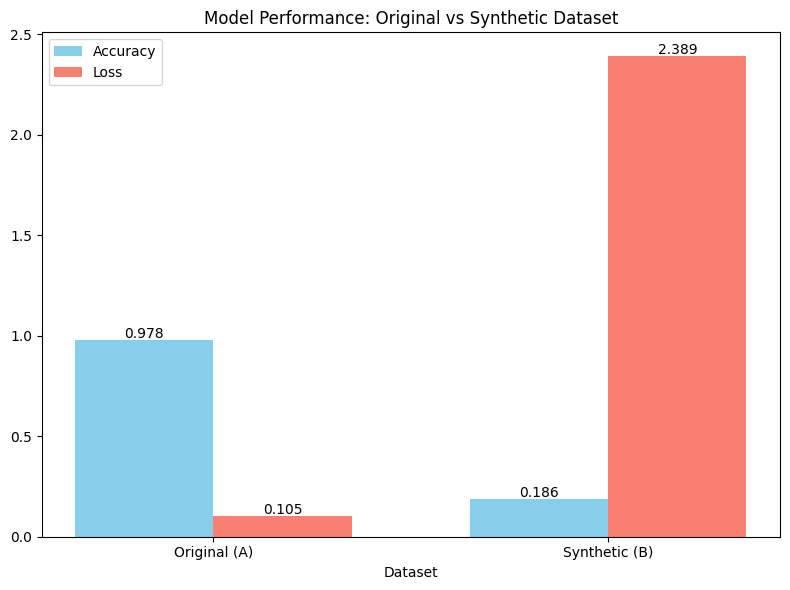

Comparison plot saved as 'dataset_comparison.png'


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load and preprocess dataset
def load_and_preprocess_data(csv_path, feature_dim=512):
    # Load CSV
    data = pd.read_csv(csv_path)

    # Define valid labels
    valid_labels = {'Bypass', 'Downloader', 'Injector', 'Payload', 'TaskExecution'}

    # Filter rows with valid labels
    original_rows = len(data)
    data = data[data['Label'].isin(valid_labels)]
    removed_rows = original_rows - len(data)
    if removed_rows > 0:
        print(f"{csv_path}: Removed {removed_rows} rows with invalid labels.")

    # Check if data is empty
    if data.empty:
        raise ValueError(f"{csv_path}: No rows remain after filtering.")

    # Parse FusionVector
    features = np.array([np.fromstring(vec, sep=' ') for vec in data['FusionVector']])

    # Validate feature dimension
    assert features.shape[1] == feature_dim, f"{csv_path}: Expected {feature_dim} features, got {features.shape[1]}"

    # Encode labels
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(data['Label'])

    # Normalize features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    # Convert to PyTorch tensors
    features = torch.FloatTensor(features)
    labels = torch.LongTensor(labels)

    return features, labels, scaler, label_encoder

# Simple MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Train and evaluate model
def train_and_evaluate(features, labels, dataset_name, test_size=0.2, epochs=50, batch_size=32, lr=0.001):
    # Split data
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=test_size, stratify=labels, random_state=42
        )
    except ValueError as e:
        print(f"{dataset_name}: Error in train_test_split: {e}")
        return None, None

    # Initialize model
    model = MLP(input_dim=512)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for i in range(0, len(X_train), batch_size):
            batch_features = X_train[i:i+batch_size]
            batch_labels = y_train[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            avg_loss = total_loss / (len(X_train) // batch_size + 1)
            print(f"{dataset_name}: Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    # Evaluate
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test).item()
        test_preds = torch.argmax(test_outputs, dim=1)
        test_accuracy = accuracy_score(y_test.numpy(), test_preds.numpy())

    print(f"{dataset_name}: Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")
    return test_accuracy, test_loss

# Visualize results
def visualize_comparison(results):
    datasets = ['Original (A)', 'Synthetic (B)']
    accuracies = [results['A']['accuracy'], results['B']['accuracy']]
    losses = [results['A']['loss'], results['B']['loss']]

    x = np.arange(len(datasets))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
    ax.bar(x + width/2, losses, width, label='Loss', color='salmon')

    ax.set_xlabel('Dataset')
    ax.set_title('Model Performance: Original vs Synthetic Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.legend()

    # Add value labels on bars
    for i, v in enumerate(accuracies):
        ax.text(i - width/2, v + 0.01, f"{v:.3f}", ha='center')
    for i, v in enumerate(losses):
        ax.text(i + width/2, v + 0.01, f"{v:.3f}", ha='center')

    plt.tight_layout()
    plt.savefig("dataset_comparison.png")
    plt.show()
    print("Comparison plot saved as 'dataset_comparison.png'")

# Main execution
if __name__ == "__main__":
    # Paths to datasets
    original_csv = "/content/drive/MyDrive/GAN/fusion_with_vector_extended.csv"  # Original dataset (Dataset A)
    synthetic_csv = "synthetic_powershell_malware.csv"  # Synthetic dataset (Dataset B)

    # Load and preprocess datasets
    try:
        features_a, labels_a, scaler_a, encoder_a = load_and_preprocess_data(original_csv)
        print("Loaded original dataset (A)")
    except Exception as e:
        print(f"Error loading original dataset: {e}")
        exit(1)

    try:
        features_b, labels_b, scaler_b, encoder_b = load_and_preprocess_data(synthetic_csv)
        print("Loaded synthetic dataset (B)")
    except Exception as e:
        print(f"Error loading synthetic dataset: {e}")
        exit(1)

    # Train and evaluate on each dataset
    results = {'A': {}, 'B': {}}

    # Dataset A (Original)
    result_a = train_and_evaluate(features_a, labels_a, "Original Dataset (A)")
    if result_a[0] is not None:
        results['A']['accuracy'], results['A']['loss'] = result_a
    else:
        print("Failed to evaluate Dataset A. Check dataset size or labels.")
        exit(1)

    # Dataset B (Synthetic)
    result_b = train_and_evaluate(features_b, labels_b, "Synthetic Dataset (B)")
    if result_b[0] is not None:
        results['B']['accuracy'], results['B']['loss'] = result_b
    else:
        print("Failed to evaluate Dataset B. Check dataset size or labels.")
        exit(1)

    # Visualize results
    visualize_comparison(results)

## Approach with discriminator is build isolated
### easy to evalute a power of blockbox discrimitor and enhanced but diffi to load

## Discriminator

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

# Load and preprocess dataset
def load_and_preprocess_data(csv_path, feature_dim=512):
    # Load CSV
    data = pd.read_csv(csv_path)

    # Parse FusionVector (space-separated string to array)
    features = np.array([np.fromstring(vec, sep=' ') for vec in data['FusionVector']])

    # Validate feature dimension
    assert features.shape[1] == feature_dim, f"Expected {feature_dim} features, got {features.shape[1]}"

    # Encode labels
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(data['Label'])

    # Normalize features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    # Convert to PyTorch tensors
    features = torch.FloatTensor(features)
    labels = torch.LongTensor(labels)

    return features, labels, scaler, label_encoder

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes=5):  # Assuming 5 classes based on the error
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)  # Output layer for num_classes
        )

    def forward(self, x):
        return self.model(x)

# Train and evaluate discriminator
def train_discriminator(discriminator, features, labels, test_size=0.2, epochs=50, batch_size=64, lr=0.0002):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, stratify=labels, random_state=42
    )

    # Optimizer and loss
    optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    class_loss = nn.CrossEntropyLoss()

    # Training loop
    discriminator.train()
    for epoch in range(epochs):
        total_loss = 0  # To accumulate loss for the epoch
        num_batches = 0  # To count batches for averaging loss

        for i in range(0, len(X_train), batch_size):
            batch_features = X_train[i:i+batch_size]
            batch_labels = y_train[i:i+batch_size]

            optimizer.zero_grad()
            outputs = discriminator(batch_features)

            # Check if any label is out of bounds and adjust if necessary
            # This step handles potential issues with the dataset
            invalid_labels = (batch_labels >= discriminator.model[-1].out_features).nonzero()
            if invalid_labels.nelement() > 0:
                # Print or handle invalid labels (e.g., replace with max valid label)
                print(f"Warning: Invalid labels found in batch: {batch_labels[invalid_labels]}")
                batch_labels[invalid_labels] = discriminator.model[-1].out_features - 1

            loss = class_loss(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()  # Accumulate loss
            num_batches += 1  # Increment batch count

        if (epoch + 1) % 10 == 0:
            avg_loss = total_loss / num_batches  # Calculate average loss
            print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")

    # Evaluate
    discriminator.eval()
    with torch.no_grad():
        test_outputs = discriminator(X_test)
        test_preds = torch.argmax(test_outputs, dim=1)
        accuracy = accuracy_score(y_test.numpy(), test_preds.numpy())

    print(f"Discriminator Test Accuracy: {accuracy:.4f}")
    return accuracy, X_train, y_train, X_test, y_test, scaler, label_encoder

# Main execution
if __name__ == "__main__":
    # Hyperparameters
    feature_dim = 512  # From dataset
    batch_size = 64
    epochs = 50
    accuracy_threshold = 0.7  # Adjust as needed

    # Load dataset (replace with your CSV path)
    csv_path = "/content/drive/MyDrive/GAN/fusion_with_vector_extended.csv"  # Placeholder
    features, labels, scaler, label_encoder = load_and_preprocess_data(csv_path, feature_dim)

    # Initialize discriminator
    discriminator = Discriminator(feature_dim)

    # Train and evaluate
    accuracy, X_train, y_train, X_test, y_test, scaler, label_encoder = train_discriminator(
        discriminator, features, labels, epochs=epochs, batch_size=batch_size
    )

    # Save model if satisfactory
    if accuracy >= accuracy_threshold:
        torch.save(discriminator.state_dict(), "discriminator_model.pth")
        print("Discriminator model saved as 'discriminator_model.pth'")
        # Save scaler and label encoder for GAN
        np.save("scaler_params.npy", [scaler.mean_, scaler.scale_])
        np.save("label_encoder_classes.npy", label_encoder.classes_)
        print("Scaler and label encoder saved")
    else:
        print("Discriminator accuracy below threshold. Adjust model or hyperparameters.")

Epoch 10/50, Average Loss: 0.1484
Epoch 20/50, Average Loss: 0.0847
Epoch 30/50, Average Loss: 0.0594
Epoch 40/50, Average Loss: 0.0459
Epoch 50/50, Average Loss: 0.0364
Discriminator Test Accuracy: 0.9720
Discriminator model saved as 'discriminator_model.pth'
Scaler and label encoder saved


## GAN with built-in generator


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load and preprocess dataset
def load_and_preprocess_data(csv_path, scaler_params, feature_dim=512):
    # Load CSV
    data = pd.read_csv(csv_path)

    # Parse FusionVector
    features = np.array([np.fromstring(vec, sep=' ') for vec in data['FusionVector']])

    # Validate feature dimension
    assert features.shape[1] == feature_dim, f"Expected {feature_dim} features, got {features.shape[1]}"

    # Load labels (assume same encoding as discriminator)
    label_encoder_classes = np.load("label_encoder_classes.npy", allow_pickle=True)
    label_map = {cls: idx for idx, cls in enumerate(label_encoder_classes)}

    # Handle NaN values in 'Label' column
    # Replace NaN with a placeholder string or a valid label
    data['Label'].fillna('unknown', inplace=True) # Replace NaN with 'unknown'

    labels = np.array([label_map.get(lbl, -1) for lbl in data['Label']])
    # Use get with a default value for unknown labels
    # -1 could represent an unknown label, adjust as needed

    # Normalize features using saved scaler
    scaler = StandardScaler()
    scaler.mean_, scaler.scale_ = scaler_params[0], scaler_params[1]
    features = scaler.transform(features)

    # Convert to PyTorch tensors
    features = torch.FloatTensor(features)
    labels = torch.LongTensor(labels)

    return features, labels, scaler

# Discriminator Model (with real/fake output)

# class Discriminator(nn.Module):
#     def __init__(self, input_dim, num_classes=5):
#         super(Discriminator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.3),
#             nn.Linear(256, 128),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.3), # Added back the missing Dropout layer
#             nn.Linear(128, num_classes)  # Added back the output layer for num_classes
#         )

#     def forward(self, x):
#         return self.model(x)
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes=5):  # Assuming 5 classes based on the error
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)  # Output layer for num_classes
        )

    def forward(self, x):
        return self.model(x)


class Generator(nn.Module): # Added Generator class
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

def train_gan(discriminator, generator, features, labels, noise_dim=100, epochs=200, batch_size=64): # Added train_gan function
    # Placeholder - replace with actual GAN training logic

    # Generate synthetic dataset
    num_samples = len(features)
    noise = torch.randn(num_samples, noise_dim)
    synthetic_data = generator(noise).detach().numpy()
    synthetic_data = scaler.inverse_transform(synthetic_data)

    # Random labels for synthetic data
    synthetic_labels = np.random.randint(0, 5, num_samples)
    synthetic_labels = label_encoder_classes[synthetic_labels]

    # Create synthetic dataset
    synthetic_df = pd.DataFrame(
        synthetic_data,
        columns=[f"feature_{i+1}" for i in range(synthetic_data.shape[1])]
    )
    synthetic_df['Label'] = synthetic_labels
    synthetic_df['Full Payload'] = ''  # Dummy column

    return synthetic_df

# Main execution
if __name__ == "__main__":
    # Hyperparameters
    feature_dim = 512
    noise_dim = 100
    batch_size = 64
    epochs = 200

    # Load dataset and scaler
    csv_path = "/content/drive/MyDrive/GAN/fusion_with_vector_extended.csv"  # Placeholder
    scaler_params = np.load("scaler_params.npy", allow_pickle=True)
    features, labels, scaler = load_and_preprocess_data(csv_path, scaler_params, feature_dim)

    label_encoder_classes = np.load("label_encoder_classes.npy", allow_pickle=True) #Load label encoder classes

    # Load discriminator
    discriminator = Discriminator(feature_dim)
    discriminator.load_state_dict(torch.load("discriminator_model.pth"))
    discriminator.eval()  # Freeze discriminator weights

    # Initialize generator
    generator = Generator(noise_dim, feature_dim)

    # Train GAN
    synthetic_df = train_gan(discriminator, generator, features, labels, noise_dim=noise_dim, epochs=epochs, batch_size=batch_size)

    # Save synthetic dataset
    synthetic_df.to_csv("synthetic_powershell_malware.csv", index=False)
    print("Synthetic dataset saved as 'synthetic_powershell_malware.csv'")


<ipython-input-18-3cd1bd604ae0>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Label'].fillna('unknown', inplace=True) # Replace NaN with 'unknown'


Synthetic dataset saved as 'synthetic_powershell_malware.csv'


In [ ]:
# prompt: load dataset and head(), synthetic_powershell_malware.csv

import pandas as pd

# Assuming 'synthetic_powershell_malware.csv' is in your current working directory
# If not, provide the correct file path
try:
    df = pd.read_csv('synthetic_powershell_malware.csv')
    print(df.head())
except FileNotFoundError:
    print("Error: 'synthetic_powershell_malware.csv' not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")


   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  -0.321576  -0.392932  -0.688882  -0.094042  -0.483731  -0.504745   
1  -0.353613  -0.373304  -0.702172  -0.131831  -0.478514  -0.470979   
2  -0.309641  -0.398533  -0.711898  -0.124499  -0.440564  -0.544499   
3  -0.308181  -0.424315  -0.695093  -0.100583  -0.472719  -0.506917   
4  -0.324091  -0.377408  -0.720342  -0.095734  -0.451657  -0.552422   

   feature_7  feature_8  feature_9  feature_10  ...  feature_505  feature_506  \
0  -0.149790  -0.184425   0.473055   -0.256498  ...     0.147626    -0.378020   
1  -0.135763  -0.179018   0.432259   -0.270265  ...     0.116773    -0.382627   
2  -0.139711  -0.167192   0.444204   -0.272017  ...     0.167514    -0.368123   
3  -0.144950  -0.193542   0.482494   -0.276501  ...     0.169986    -0.399970   
4  -0.138363  -0.164719   0.469896   -0.290826  ...     0.123359    -0.398386   

   feature_507  feature_508  feature_509  feature_510  feature_511  \
0    -0.487029  